In [37]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import fbeta_score

In [2]:
# Save the train and test DataFrames
X_TRAIN_DIR = "processed_data/glcm/X_train.pkl"
y_TRAIN_DIR = "processed_data/glcm/y_train.pkl"
X_TEST_DIR = "processed_data/glcm/X_test.pkl"
y_TEST_DIR = "processed_data/glcm/y_test.pkl"

X_train = pd.read_pickle(X_TRAIN_DIR)
y_train = pd.read_pickle(y_TRAIN_DIR)
X_test = pd.read_pickle(X_TEST_DIR)
y_test = pd.read_pickle(y_TEST_DIR)

In [40]:
def logistic_regression(X_train, y_train, X_test, y_test, c, reg):
    """
    Perform logistic regression, evaluate the model, and create a confusion matrix.

    Parameters:
    X_train (torch.Tensor): Training features.
    y_train (torch.Tensor): Training labels.
    X_test (torch.Tensor): Testing features.
    y_test (torch.Tensor): Testing labels.

    Returns:
    None
    """

    # Fit the logistic regression model
    model = LogisticRegression(solver="lbfgs", C=c, penalty=reg, multi_class='multinomial', max_iter=100000)
    model.fit(X_train, y_train) 

    # Predict labels
    y_pred = model.predict(X_test)

    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    f2_score = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    print("F2 Score:", f2_score)

    # Calculate MCC using true labels and predicted labels
    mcc = matthews_corrcoef(y_test, y_pred)
    print("Matthews Correlation Coefficient:", mcc)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

c:\Users\jonas\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


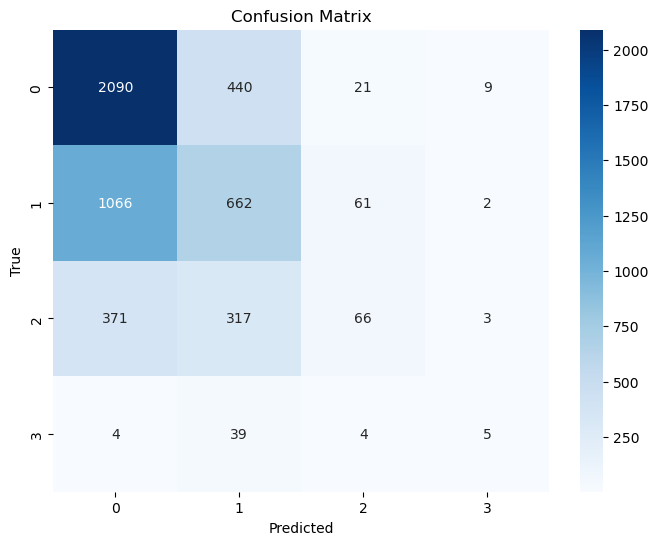

F2 Score: 0.526062867287014
Matthews Correlation Coefficient: 0.2002037927016934
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.82      0.69      2560
           1       0.45      0.37      0.41      1791
           2       0.43      0.09      0.15       757
           3       0.26      0.10      0.14        52

    accuracy                           0.55      5160
   macro avg       0.44      0.34      0.34      5160
weighted avg       0.52      0.55      0.50      5160



In [41]:
logistic_regression(X_train, y_train, X_test, y_test, 1, "l2")

In [52]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, fbeta_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore specific warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def objective(trial):
    # Define the search space for hyperparameters
    c = trial.suggest_loguniform('C', 1e-5, 1e5)
    reg = trial.suggest_categorical('penalty', ['l2','none'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    multi_class = trial.suggest_categorical('multi_class', ['ovr', 'multinomial'])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    # Train and evaluate the logistic regression model
    f2_score, mcc = logistic_regression_tune(X_train, y_train, X_test, y_test, c, reg, max_iter, multi_class, class_weight)

    # Optimize for F2 score, you can change this to MCC or other metrics
    return f2_score

def logistic_regression_tune(X_train, y_train, X_test, y_test, c, reg, max_iter, multi_class, class_weight):
    # Fit the logistic regression model
    model = LogisticRegression(solver="lbfgs", C=c, penalty=reg, multi_class=multi_class, max_iter=max_iter, class_weight=class_weight)
    model.fit(X_train, y_train)

    # Predict labels
    y_pred = model.predict(X_test)

    f2_score = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    print("F2 Score:", f2_score)

    # Calculate MCC using true labels and predicted labels
    mcc = matthews_corrcoef(y_test, y_pred)
    print("Matthews Correlation Coefficient:", mcc)
    print("")

    return f2_score, mcc

# Assuming X_train, y_train, X_test, y_test are your training and testing data
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2023-11-12 12:51:58,142] A new study created in memory with name: no-name-4cedf3ef-44b2-46a1-8bb5-a40b6449116e
[I 2023-11-12 12:51:59,244] Trial 0 finished with value: 0.41808137286251873 and parameters: {'C': 8.501349260363358e-05, 'penalty': 'none', 'max_iter': 927, 'multi_class': 'multinomial', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.41808137286251873.


F2 Score: 0.41808137286251873
Matthews Correlation Coefficient: 0.14869797517037547



[I 2023-11-12 12:51:59,532] Trial 1 finished with value: 0.4155665167153596 and parameters: {'C': 5642.541093292016, 'penalty': 'l2', 'max_iter': 224, 'multi_class': 'multinomial', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.41808137286251873.


F2 Score: 0.4155665167153596
Matthews Correlation Coefficient: 0.14392694169628728



[I 2023-11-12 12:51:59,786] Trial 2 finished with value: 0.3925121291115012 and parameters: {'C': 1506.04973781709, 'penalty': 'none', 'max_iter': 199, 'multi_class': 'multinomial', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.41808137286251873.


F2 Score: 0.3925121291115012
Matthews Correlation Coefficient: 0.11451713750476697



[I 2023-11-12 12:52:00,277] Trial 3 finished with value: 0.5068238138903823 and parameters: {'C': 732.5287387464939, 'penalty': 'none', 'max_iter': 255, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 3 with value: 0.5068238138903823.


F2 Score: 0.5068238138903823
Matthews Correlation Coefficient: 0.16582772561312764



[I 2023-11-12 12:52:01,157] Trial 4 finished with value: 0.4627182817498967 and parameters: {'C': 20.91575343053814, 'penalty': 'l2', 'max_iter': 520, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 3 with value: 0.5068238138903823.


F2 Score: 0.4627182817498967
Matthews Correlation Coefficient: 0.19338323554113002



[I 2023-11-12 12:52:01,455] Trial 5 finished with value: 0.37969893751499467 and parameters: {'C': 319.63260592952076, 'penalty': 'none', 'max_iter': 194, 'multi_class': 'multinomial', 'class_weight': 'balanced'}. Best is trial 3 with value: 0.5068238138903823.


F2 Score: 0.37969893751499467
Matthews Correlation Coefficient: 0.10801369769861144



[I 2023-11-12 12:52:01,904] Trial 6 finished with value: 0.43260206555610936 and parameters: {'C': 429.0037885187671, 'penalty': 'l2', 'max_iter': 204, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 3 with value: 0.5068238138903823.


F2 Score: 0.43260206555610936
Matthews Correlation Coefficient: 0.15242609507921343



[I 2023-11-12 12:52:02,908] Trial 7 finished with value: 0.4641588003783697 and parameters: {'C': 16.842571352859807, 'penalty': 'none', 'max_iter': 540, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 3 with value: 0.5068238138903823.


F2 Score: 0.4641588003783697
Matthews Correlation Coefficient: 0.19540195362606766



[I 2023-11-12 12:52:03,527] Trial 8 finished with value: 0.5054375740110014 and parameters: {'C': 35.83568317316713, 'penalty': 'none', 'max_iter': 330, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 3 with value: 0.5068238138903823.


F2 Score: 0.5054375740110014
Matthews Correlation Coefficient: 0.16378168214950717



[I 2023-11-12 12:52:03,945] Trial 9 finished with value: 0.5072419491421267 and parameters: {'C': 1.68111372355575, 'penalty': 'none', 'max_iter': 202, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 9 with value: 0.5072419491421267.


F2 Score: 0.5072419491421267
Matthews Correlation Coefficient: 0.16725280208897483



[I 2023-11-12 12:52:05,058] Trial 10 finished with value: 0.5101374793731192 and parameters: {'C': 0.07430825018402842, 'penalty': 'l2', 'max_iter': 840, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 10 with value: 0.5101374793731192.


F2 Score: 0.5101374793731192
Matthews Correlation Coefficient: 0.17223939029696933



[I 2023-11-12 12:52:06,410] Trial 11 finished with value: 0.5136985795364748 and parameters: {'C': 0.07163965928425259, 'penalty': 'l2', 'max_iter': 917, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 11 with value: 0.5136985795364748.


F2 Score: 0.5136985795364748
Matthews Correlation Coefficient: 0.17783497941817117



[I 2023-11-12 12:52:07,826] Trial 12 finished with value: 0.5113513442296613 and parameters: {'C': 0.02378550939899192, 'penalty': 'l2', 'max_iter': 971, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 11 with value: 0.5136985795364748.


F2 Score: 0.5113513442296613
Matthews Correlation Coefficient: 0.17431498935295034



[I 2023-11-12 12:52:08,924] Trial 13 finished with value: 0.5094529154172192 and parameters: {'C': 0.02517306263448139, 'penalty': 'l2', 'max_iter': 754, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 11 with value: 0.5136985795364748.


F2 Score: 0.5094529154172192
Matthews Correlation Coefficient: 0.17147792553590901



[I 2023-11-12 12:52:09,955] Trial 14 finished with value: 0.5087548822809222 and parameters: {'C': 0.002971687359537949, 'penalty': 'l2', 'max_iter': 995, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 11 with value: 0.5136985795364748.


F2 Score: 0.5087548822809222
Matthews Correlation Coefficient: 0.1705978199724838



[I 2023-11-12 12:52:11,034] Trial 15 finished with value: 0.5103190358205485 and parameters: {'C': 0.22582698478972946, 'penalty': 'l2', 'max_iter': 699, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 11 with value: 0.5136985795364748.


F2 Score: 0.5103190358205485
Matthews Correlation Coefficient: 0.17293521279822888



[I 2023-11-12 12:52:11,968] Trial 16 finished with value: 0.5056363262830278 and parameters: {'C': 0.001099952557108747, 'penalty': 'l2', 'max_iter': 703, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 11 with value: 0.5136985795364748.


F2 Score: 0.5056363262830278
Matthews Correlation Coefficient: 0.1647571337629996



[I 2023-11-12 12:52:13,375] Trial 17 finished with value: 0.5141432151462932 and parameters: {'C': 0.883623454949932, 'penalty': 'l2', 'max_iter': 866, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 17 with value: 0.5141432151462932.


F2 Score: 0.5141432151462932
Matthews Correlation Coefficient: 0.18025097415648272



[I 2023-11-12 12:52:14,474] Trial 18 finished with value: 0.5036177493775065 and parameters: {'C': 1.1204900671251568, 'penalty': 'l2', 'max_iter': 879, 'multi_class': 'multinomial', 'class_weight': None}. Best is trial 17 with value: 0.5141432151462932.


F2 Score: 0.5036177493775065
Matthews Correlation Coefficient: 0.15831221661966213



[I 2023-11-12 12:52:16,259] Trial 19 finished with value: 0.5125091289910412 and parameters: {'C': 82941.71081285637, 'penalty': 'l2', 'max_iter': 809, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 17 with value: 0.5141432151462932.


F2 Score: 0.5125091289910412
Matthews Correlation Coefficient: 0.17509379182013188



[I 2023-11-12 12:52:16,743] Trial 20 finished with value: 0.468206425470913 and parameters: {'C': 1.633269165934078e-05, 'penalty': 'l2', 'max_iter': 423, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 17 with value: 0.5141432151462932.


F2 Score: 0.468206425470913
Matthews Correlation Coefficient: 0.11487249894093012



[I 2023-11-12 12:52:18,181] Trial 21 finished with value: 0.5131552273727804 and parameters: {'C': 2.8053487740578436, 'penalty': 'l2', 'max_iter': 807, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 17 with value: 0.5141432151462932.


F2 Score: 0.5131552273727804
Matthews Correlation Coefficient: 0.17838761085354338



[I 2023-11-12 12:52:19,660] Trial 22 finished with value: 0.5131936797437389 and parameters: {'C': 0.48239426886055353, 'penalty': 'l2', 'max_iter': 647, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 17 with value: 0.5141432151462932.


F2 Score: 0.5131936797437389
Matthews Correlation Coefficient: 0.17587400999877012



[I 2023-11-12 12:52:20,834] Trial 23 finished with value: 0.508502355616942 and parameters: {'C': 0.22950928250190944, 'penalty': 'l2', 'max_iter': 632, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 17 with value: 0.5141432151462932.


F2 Score: 0.508502355616942
Matthews Correlation Coefficient: 0.16903158505876817



[I 2023-11-12 12:52:21,976] Trial 24 finished with value: 0.5099306264394337 and parameters: {'C': 0.3291029366251991, 'penalty': 'l2', 'max_iter': 621, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 17 with value: 0.5141432151462932.


F2 Score: 0.5099306264394337
Matthews Correlation Coefficient: 0.17216340869574728



[I 2023-11-12 12:52:23,890] Trial 25 finished with value: 0.5138300067137814 and parameters: {'C': 4.293439711805405, 'penalty': 'l2', 'max_iter': 912, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 17 with value: 0.5141432151462932.


F2 Score: 0.5138300067137814
Matthews Correlation Coefficient: 0.17710840606457876



[I 2023-11-12 12:52:25,030] Trial 26 finished with value: 0.5033069274517445 and parameters: {'C': 3.403451945804448, 'penalty': 'l2', 'max_iter': 945, 'multi_class': 'multinomial', 'class_weight': None}. Best is trial 17 with value: 0.5141432151462932.


F2 Score: 0.5033069274517445
Matthews Correlation Coefficient: 0.15776088872557742



[I 2023-11-12 12:52:26,037] Trial 27 finished with value: 0.5094178176780632 and parameters: {'C': 0.03388931741101877, 'penalty': 'l2', 'max_iter': 889, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 17 with value: 0.5141432151462932.


F2 Score: 0.5094178176780632
Matthews Correlation Coefficient: 0.17172405699303805



[I 2023-11-12 12:52:27,370] Trial 28 finished with value: 0.5121621600691729 and parameters: {'C': 6.4182845658986345, 'penalty': 'l2', 'max_iter': 741, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 17 with value: 0.5141432151462932.


F2 Score: 0.5121621600691729
Matthews Correlation Coefficient: 0.17646082190265597



[I 2023-11-12 12:52:28,456] Trial 29 finished with value: 0.50559290467017 and parameters: {'C': 0.0029407030066078235, 'penalty': 'l2', 'max_iter': 909, 'multi_class': 'multinomial', 'class_weight': None}. Best is trial 17 with value: 0.5141432151462932.


F2 Score: 0.50559290467017
Matthews Correlation Coefficient: 0.16351140063712982



[I 2023-11-12 12:52:29,811] Trial 30 finished with value: 0.51315413743295 and parameters: {'C': 68.17855636511689, 'penalty': 'l2', 'max_iter': 846, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 17 with value: 0.5141432151462932.


F2 Score: 0.51315413743295
Matthews Correlation Coefficient: 0.178805965268939



[I 2023-11-12 12:52:31,633] Trial 31 finished with value: 0.5202291085244083 and parameters: {'C': 1.4579896082327157, 'penalty': 'l2', 'max_iter': 931, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5202291085244083
Matthews Correlation Coefficient: 0.19004313031159886



[I 2023-11-12 12:52:31,895] Trial 32 finished with value: 0.5074570028558762 and parameters: {'C': 1.4432543291237592, 'penalty': 'l2', 'max_iter': 104, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5074570028558762
Matthews Correlation Coefficient: 0.16851426725166124



[I 2023-11-12 12:52:33,029] Trial 33 finished with value: 0.5118856808547344 and parameters: {'C': 6.105466450040883, 'penalty': 'l2', 'max_iter': 945, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5118856808547344
Matthews Correlation Coefficient: 0.17588202671141787



[I 2023-11-12 12:52:33,995] Trial 34 finished with value: 0.41583947786814635 and parameters: {'C': 0.11986038710013168, 'penalty': 'l2', 'max_iter': 767, 'multi_class': 'multinomial', 'class_weight': 'balanced'}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.41583947786814635
Matthews Correlation Coefficient: 0.1429111844526771



[I 2023-11-12 12:52:35,478] Trial 35 finished with value: 0.5137636196225014 and parameters: {'C': 68.39159947018042, 'penalty': 'none', 'max_iter': 989, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5137636196225014
Matthews Correlation Coefficient: 0.18012252991342506



[I 2023-11-12 12:52:36,971] Trial 36 finished with value: 0.4612080767226544 and parameters: {'C': 91.01717838572333, 'penalty': 'none', 'max_iter': 989, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.4612080767226544
Matthews Correlation Coefficient: 0.19144475179248585



[I 2023-11-12 12:52:38,011] Trial 37 finished with value: 0.5036238139739817 and parameters: {'C': 10.142986357424032, 'penalty': 'none', 'max_iter': 853, 'multi_class': 'multinomial', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5036238139739817
Matthews Correlation Coefficient: 0.15840987596714234



[I 2023-11-12 12:52:39,581] Trial 38 finished with value: 0.4612431186868772 and parameters: {'C': 75.13984703530363, 'penalty': 'none', 'max_iter': 937, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.4612431186868772
Matthews Correlation Coefficient: 0.19131844074043516



[I 2023-11-12 12:52:41,155] Trial 39 finished with value: 0.5137599376456838 and parameters: {'C': 19.991279001684642, 'penalty': 'none', 'max_iter': 1000, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5137599376456838
Matthews Correlation Coefficient: 0.1800144794548238



[I 2023-11-12 12:52:42,631] Trial 40 finished with value: 0.46162822372684303 and parameters: {'C': 222.02122963865654, 'penalty': 'none', 'max_iter': 792, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.46162822372684303
Matthews Correlation Coefficient: 0.19305817686474655



[I 2023-11-12 12:52:44,067] Trial 41 finished with value: 0.5137636196225014 and parameters: {'C': 18.24881845247069, 'penalty': 'none', 'max_iter': 989, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5137636196225014
Matthews Correlation Coefficient: 0.18012252991342506



[I 2023-11-12 12:52:45,446] Trial 42 finished with value: 0.5130814809363242 and parameters: {'C': 16.044597734227352, 'penalty': 'none', 'max_iter': 886, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5130814809363242
Matthews Correlation Coefficient: 0.17858908628455322



[I 2023-11-12 12:52:46,885] Trial 43 finished with value: 0.5137636196225014 and parameters: {'C': 1952.04491497728, 'penalty': 'none', 'max_iter': 946, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5137636196225014
Matthews Correlation Coefficient: 0.18012252991342506



[I 2023-11-12 12:52:48,309] Trial 44 finished with value: 0.5130814809363242 and parameters: {'C': 5.413681730884256, 'penalty': 'none', 'max_iter': 849, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5130814809363242
Matthews Correlation Coefficient: 0.17858908628455322



[I 2023-11-12 12:52:49,756] Trial 45 finished with value: 0.51331386692805 and parameters: {'C': 1.1898800784356354, 'penalty': 'none', 'max_iter': 909, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.51331386692805
Matthews Correlation Coefficient: 0.17908305390981957



[I 2023-11-12 12:52:50,538] Trial 46 finished with value: 0.5082786080918792 and parameters: {'C': 26.159574284931022, 'penalty': 'none', 'max_iter': 410, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5082786080918792
Matthews Correlation Coefficient: 0.17185893468833402



[I 2023-11-12 12:52:51,953] Trial 47 finished with value: 0.5137636196225014 and parameters: {'C': 0.6422286003327501, 'penalty': 'none', 'max_iter': 966, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5137636196225014
Matthews Correlation Coefficient: 0.18012252991342506



[I 2023-11-12 12:52:53,026] Trial 48 finished with value: 0.4181545096613358 and parameters: {'C': 166.17410709804744, 'penalty': 'none', 'max_iter': 873, 'multi_class': 'multinomial', 'class_weight': 'balanced'}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.4181545096613358
Matthews Correlation Coefficient: 0.1470108464361093



[I 2023-11-12 12:52:54,763] Trial 49 finished with value: 0.5132787229042342 and parameters: {'C': 3.2390909171401803, 'penalty': 'none', 'max_iter': 822, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5132787229042342
Matthews Correlation Coefficient: 0.17886682835965656



[I 2023-11-12 12:52:56,450] Trial 50 finished with value: 0.5132661994292225 and parameters: {'C': 38.91755858651997, 'penalty': 'none', 'max_iter': 920, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5132661994292225
Matthews Correlation Coefficient: 0.1786506378172519



[I 2023-11-12 12:52:58,272] Trial 51 finished with value: 0.5137636196225014 and parameters: {'C': 630.5217278720165, 'penalty': 'none', 'max_iter': 942, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5137636196225014
Matthews Correlation Coefficient: 0.18012252991342506



[I 2023-11-12 12:53:00,073] Trial 52 finished with value: 0.5137636196225014 and parameters: {'C': 259.9489717093965, 'penalty': 'none', 'max_iter': 966, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5137636196225014
Matthews Correlation Coefficient: 0.18012252991342506



[I 2023-11-12 12:53:02,287] Trial 53 finished with value: 0.5137599376456838 and parameters: {'C': 2690.5577990547317, 'penalty': 'none', 'max_iter': 999, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5137599376456838
Matthews Correlation Coefficient: 0.1800144794548238



[I 2023-11-12 12:53:04,262] Trial 54 finished with value: 0.5137636196225014 and parameters: {'C': 1638.3824573989361, 'penalty': 'none', 'max_iter': 965, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5137636196225014
Matthews Correlation Coefficient: 0.18012252991342506



[I 2023-11-12 12:53:06,151] Trial 55 finished with value: 0.51331386692805 and parameters: {'C': 554.0160994170028, 'penalty': 'none', 'max_iter': 903, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.51331386692805
Matthews Correlation Coefficient: 0.17908305390981957



[I 2023-11-12 12:53:08,152] Trial 56 finished with value: 0.5128049703127052 and parameters: {'C': 2.003933502844152, 'penalty': 'l2', 'max_iter': 868, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5128049703127052
Matthews Correlation Coefficient: 0.17510441092231968



[I 2023-11-12 12:53:09,389] Trial 57 finished with value: 0.5144684801955256 and parameters: {'C': 10.586459525867644, 'penalty': 'l2', 'max_iter': 473, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5144684801955256
Matthews Correlation Coefficient: 0.1809867892509069



[I 2023-11-12 12:53:10,553] Trial 58 finished with value: 0.5133628105582354 and parameters: {'C': 10.438555838527103, 'penalty': 'l2', 'max_iter': 445, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5133628105582354
Matthews Correlation Coefficient: 0.17541651979879022



[I 2023-11-12 12:53:11,856] Trial 59 finished with value: 0.5142170118701817 and parameters: {'C': 0.732769735039303, 'penalty': 'l2', 'max_iter': 490, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5142170118701817
Matthews Correlation Coefficient: 0.17826230957338085



[I 2023-11-12 12:53:12,509] Trial 60 finished with value: 0.5092933565889228 and parameters: {'C': 0.685062235800887, 'penalty': 'l2', 'max_iter': 500, 'multi_class': 'multinomial', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5092933565889228
Matthews Correlation Coefficient: 0.16885700546553825



[I 2023-11-12 12:53:13,687] Trial 61 finished with value: 0.5121785236787452 and parameters: {'C': 1.607621333703645, 'penalty': 'l2', 'max_iter': 559, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5121785236787452
Matthews Correlation Coefficient: 0.17667276818074024



[I 2023-11-12 12:53:14,584] Trial 62 finished with value: 0.5120844792024182 and parameters: {'C': 4.098887925351019, 'penalty': 'l2', 'max_iter': 363, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5120844792024182
Matthews Correlation Coefficient: 0.1754673555369028



[I 2023-11-12 12:53:15,925] Trial 63 finished with value: 0.5111597676752615 and parameters: {'C': 0.4340480392250049, 'penalty': 'l2', 'max_iter': 486, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5111597676752615
Matthews Correlation Coefficient: 0.1729407536590569



[I 2023-11-12 12:53:17,371] Trial 64 finished with value: 0.5101598037624578 and parameters: {'C': 12.136611394445914, 'penalty': 'l2', 'max_iter': 546, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5101598037624578
Matthews Correlation Coefficient: 0.16973477428158057



[I 2023-11-12 12:53:18,944] Trial 65 finished with value: 0.5140141310062392 and parameters: {'C': 31.453772693524392, 'penalty': 'l2', 'max_iter': 581, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5140141310062392
Matthews Correlation Coefficient: 0.1773971521096176



[I 2023-11-12 12:53:19,683] Trial 66 finished with value: 0.5127330126433671 and parameters: {'C': 1.0240818771924929, 'penalty': 'l2', 'max_iter': 292, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5127330126433671
Matthews Correlation Coefficient: 0.17686943271345154



[I 2023-11-12 12:53:21,310] Trial 67 finished with value: 0.5141669437641259 and parameters: {'C': 42.57551491340999, 'penalty': 'l2', 'max_iter': 600, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5141669437641259
Matthews Correlation Coefficient: 0.1782259954487913



[I 2023-11-12 12:53:22,752] Trial 68 finished with value: 0.5122728797369679 and parameters: {'C': 3.084635262944771, 'penalty': 'l2', 'max_iter': 590, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5122728797369679
Matthews Correlation Coefficient: 0.17392661983732915



[I 2023-11-12 12:53:24,511] Trial 69 finished with value: 0.4751160752495284 and parameters: {'C': 0.1953587733301801, 'penalty': 'l2', 'max_iter': 691, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.4751160752495284
Matthews Correlation Coefficient: 0.20484824888567058



[I 2023-11-12 12:53:26,049] Trial 70 finished with value: 0.5125915729057458 and parameters: {'C': 6.735562215822334, 'penalty': 'l2', 'max_iter': 593, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5125915729057458
Matthews Correlation Coefficient: 0.17588292621591525



[I 2023-11-12 12:53:27,103] Trial 71 finished with value: 0.5114581348280142 and parameters: {'C': 52.61731511077413, 'penalty': 'l2', 'max_iter': 456, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5114581348280142
Matthews Correlation Coefficient: 0.17569217074980661



[I 2023-11-12 12:53:28,225] Trial 72 finished with value: 0.5135703626554665 and parameters: {'C': 85.342387528158, 'penalty': 'l2', 'max_iter': 516, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5135703626554665
Matthews Correlation Coefficient: 0.17959363377276308



[I 2023-11-12 12:53:29,262] Trial 73 finished with value: 0.5142677300375054 and parameters: {'C': 33.38201432924761, 'penalty': 'l2', 'max_iter': 382, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5142677300375054
Matthews Correlation Coefficient: 0.1779711987469438



[I 2023-11-12 12:53:30,094] Trial 74 finished with value: 0.5109623443568256 and parameters: {'C': 24.14352833943555, 'penalty': 'l2', 'max_iter': 373, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5109623443568256
Matthews Correlation Coefficient: 0.17218238090112153



[I 2023-11-12 12:53:31,148] Trial 75 finished with value: 0.5121761364329779 and parameters: {'C': 8.532588634013415, 'penalty': 'l2', 'max_iter': 468, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5121761364329779
Matthews Correlation Coefficient: 0.17701965281075616



[I 2023-11-12 12:53:32,267] Trial 76 finished with value: 0.5121375966867348 and parameters: {'C': 29.118376301481693, 'penalty': 'l2', 'max_iter': 424, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5121375966867348
Matthews Correlation Coefficient: 0.1770942466279004



[I 2023-11-12 12:53:33,106] Trial 77 finished with value: 0.5051826747365067 and parameters: {'C': 3.9625558161385026, 'penalty': 'l2', 'max_iter': 660, 'multi_class': 'multinomial', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5051826747365067
Matthews Correlation Coefficient: 0.16105616620132068



[I 2023-11-12 12:53:34,126] Trial 78 finished with value: 0.5117375863263893 and parameters: {'C': 1.8517431881052222, 'penalty': 'l2', 'max_iter': 384, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5117375863263893
Matthews Correlation Coefficient: 0.1732031416543046



[I 2023-11-12 12:53:34,934] Trial 79 finished with value: 0.4445472774337109 and parameters: {'C': 0.8418175856488742, 'penalty': 'l2', 'max_iter': 314, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.4445472774337109
Matthews Correlation Coefficient: 0.16822442587505115



[I 2023-11-12 12:53:36,432] Trial 80 finished with value: 0.5150009788410786 and parameters: {'C': 13.85603914772897, 'penalty': 'l2', 'max_iter': 581, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5150009788410786
Matthews Correlation Coefficient: 0.182035881378291



[I 2023-11-12 12:53:37,816] Trial 81 finished with value: 0.515958031126823 and parameters: {'C': 12.073154048738784, 'penalty': 'l2', 'max_iter': 568, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.515958031126823
Matthews Correlation Coefficient: 0.18082072659979345



[I 2023-11-12 12:53:39,332] Trial 82 finished with value: 0.515493071576145 and parameters: {'C': 40.31887366334213, 'penalty': 'l2', 'max_iter': 584, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.515493071576145
Matthews Correlation Coefficient: 0.17977696411430788



[I 2023-11-12 12:53:40,446] Trial 83 finished with value: 0.5132698401468607 and parameters: {'C': 13.968490607967285, 'penalty': 'l2', 'max_iter': 522, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5132698401468607
Matthews Correlation Coefficient: 0.17856939621892887



[I 2023-11-12 12:53:42,068] Trial 84 finished with value: 0.5134737133481849 and parameters: {'C': 119.21011665467992, 'penalty': 'l2', 'max_iter': 616, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5134737133481849
Matthews Correlation Coefficient: 0.17645805099861828



[I 2023-11-12 12:53:43,310] Trial 85 finished with value: 0.5121220962244257 and parameters: {'C': 52.0577232143302, 'penalty': 'l2', 'max_iter': 573, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5121220962244257
Matthews Correlation Coefficient: 0.17625743020208598



[I 2023-11-12 12:53:44,703] Trial 86 finished with value: 0.5166606520454997 and parameters: {'C': 149.91702268645366, 'penalty': 'l2', 'max_iter': 530, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5166606520454997
Matthews Correlation Coefficient: 0.1820033119809797



[I 2023-11-12 12:53:46,115] Trial 87 finished with value: 0.5140671586085049 and parameters: {'C': 313.49638045935484, 'penalty': 'l2', 'max_iter': 530, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5140671586085049
Matthews Correlation Coefficient: 0.17766883177414425



[I 2023-11-12 12:53:47,371] Trial 88 finished with value: 0.5151144526471648 and parameters: {'C': 42.89393895209657, 'penalty': 'l2', 'max_iter': 475, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5151144526471648
Matthews Correlation Coefficient: 0.18014567919865854



[I 2023-11-12 12:53:47,991] Trial 89 finished with value: 0.5079385555144411 and parameters: {'C': 114.78463824379028, 'penalty': 'l2', 'max_iter': 482, 'multi_class': 'multinomial', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5079385555144411
Matthews Correlation Coefficient: 0.1662694562180471



[I 2023-11-12 12:53:49,140] Trial 90 finished with value: 0.5098591693300436 and parameters: {'C': 156.34395756307973, 'penalty': 'l2', 'max_iter': 437, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5098591693300436
Matthews Correlation Coefficient: 0.17089237680063032



[I 2023-11-12 12:53:50,672] Trial 91 finished with value: 0.5142194713039316 and parameters: {'C': 20.28835284626954, 'penalty': 'l2', 'max_iter': 610, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5142194713039316
Matthews Correlation Coefficient: 0.177504013122806



[I 2023-11-12 12:53:52,169] Trial 92 finished with value: 0.5139438058656726 and parameters: {'C': 15.35132932044052, 'penalty': 'l2', 'max_iter': 558, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5139438058656726
Matthews Correlation Coefficient: 0.17748982986673403



[I 2023-11-12 12:53:53,520] Trial 93 finished with value: 0.5122021454462307 and parameters: {'C': 7.607077692126068, 'penalty': 'l2', 'max_iter': 507, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5122021454462307
Matthews Correlation Coefficient: 0.17411830325258348



[I 2023-11-12 12:53:55,208] Trial 94 finished with value: 0.5130617884760306 and parameters: {'C': 22.441450142223776, 'penalty': 'l2', 'max_iter': 660, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5130617884760306
Matthews Correlation Coefficient: 0.17567373870290728



[I 2023-11-12 12:53:56,265] Trial 95 finished with value: 0.5112874916716393 and parameters: {'C': 45.2012729936117, 'penalty': 'l2', 'max_iter': 404, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5112874916716393
Matthews Correlation Coefficient: 0.17824632856263056



[I 2023-11-12 12:53:56,901] Trial 96 finished with value: 0.5051129326437336 and parameters: {'C': 9.81261422576635, 'penalty': 'l2', 'max_iter': 234, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5051129326437336
Matthews Correlation Coefficient: 0.16265762651720098



[I 2023-11-12 12:53:57,904] Trial 97 finished with value: 0.5135804569980555 and parameters: {'C': 181.4356880360832, 'penalty': 'l2', 'max_iter': 471, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5135804569980555
Matthews Correlation Coefficient: 0.17876146057172



[I 2023-11-12 12:53:58,679] Trial 98 finished with value: 0.43910883762260045 and parameters: {'C': 408.2399608080576, 'penalty': 'l2', 'max_iter': 342, 'multi_class': 'ovr', 'class_weight': 'balanced'}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.43910883762260045
Matthews Correlation Coefficient: 0.15467719544511022



[I 2023-11-12 12:54:00,115] Trial 99 finished with value: 0.5127754149116064 and parameters: {'C': 5.657478271652095, 'penalty': 'l2', 'max_iter': 544, 'multi_class': 'ovr', 'class_weight': None}. Best is trial 31 with value: 0.5202291085244083.


F2 Score: 0.5127754149116064
Matthews Correlation Coefficient: 0.17527002964881228

Best Hyperparameters: {'C': 1.4579896082327157, 'penalty': 'l2', 'max_iter': 931, 'multi_class': 'ovr', 'class_weight': None}


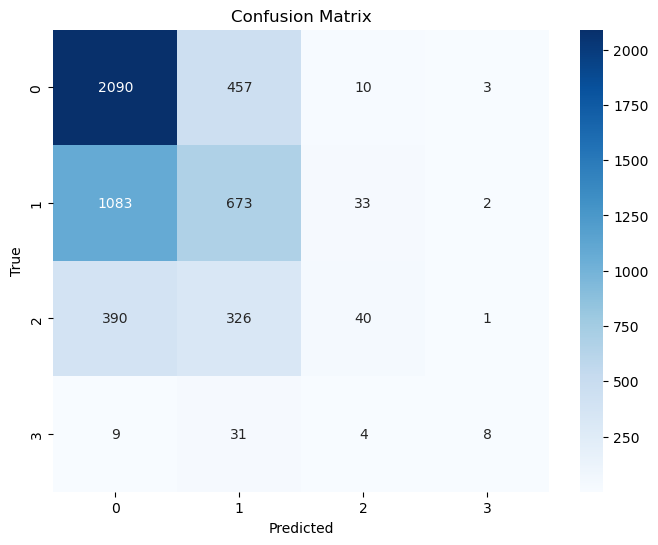

F2 Score: 0.5216063786552175
Matthews Correlation Coefficient: 0.19098678109778922
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.82      0.68      2560
           1       0.45      0.38      0.41      1791
           2       0.46      0.05      0.09       757
           3       0.57      0.15      0.24        52

    accuracy                           0.54      5160
   macro avg       0.52      0.35      0.36      5160
weighted avg       0.52      0.54      0.50      5160



In [51]:
best_params

best_f2_score, best_mcc = logistic_regression(X_train, y_train, X_test, y_test, best_params['C'], best_params['penalty'],best_params['max_iter'], best_params['multi_class'],best_params['class_weight'])